# Regime Prediction Models for the Indian Market

### Data Sources:
1. Yahoo Finance
2. Trendlyne
3. Ticker Tape
4. FRED
5. OCED
6. JKP Factor Liibrary
7. Money Control

### Macro Features:
1. Inflation
2. Interest Rate
3. USD / INR Exchange Rate
4. Global Equity Returns
5. Leading Composite Index
6. Market Cap to GDP Ratio

### Investor Sentiment Features:
1. Ticker Tape Mood Index

### Idiosyncratic Features
1. P/E
2. Momentum - 1, 6, months


In [1456]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from fredapi import Fred


# Turn off warnings
warnings.filterwarnings("ignore")

### NIFTY 50 Historical Data
We get latest data from yahoo finance and combine it with older data

In [1457]:
# Define ticker and date rangticker = "BSE-500.BO"
start_date = "1980-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

ticker = '^NSEI'
# Download data
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data = data[['Close']]
yf_market_data = data['Close'].resample('ME').last()

display(yf_market_data.head())


nifty_historical = pd.read_csv("./data/NIFTY 50_Historical_PRICE.csv")
nifty_historical['Date'] = pd.to_datetime(nifty_historical['Date'])
nifty_historical = nifty_historical.set_index('Date').resample('ME').ffill()
nifty_historical = nifty_historical[:yf_market_data.index[0]-pd.DateOffset(days=15)]

display(nifty_historical.tail())
nifty_historical  = pd.DataFrame(nifty_historical['Close'])
nifty_historical = nifty_historical.rename(columns = {'Close': '^NSEI'})

market_data = pd.concat([nifty_historical, yf_market_data], axis=0)
market_data.iloc[5:]

[*********************100%***********************]  1 of 1 completed


Ticker,^NSEI
Date,
2007-09-30,5021.350098
2007-10-31,5900.649902
2007-11-30,5762.750000
2007-12-31,6138.600098
2008-01-31,5137.450195


,Index Name,Open,High,Low,Close
Date,,,,,
2007-04-30,NIFTY 50,4081.60,4096.90,4028.90,4087.90
2007-05-31,NIFTY 50,4250.25,4306.75,4250.25,4295.80
2007-06-30,NIFTY 50,4282.40,4321.35,4280.95,4318.30
2007-07-31,NIFTY 50,4444.25,4534.20,4432.85,4528.85
2007-08-31,NIFTY 50,4412.60,4471.30,4403.00,4464.00


,^NSEI
Date,
1990-12-31,330.860000
1991-01-31,314.360000
1991-02-28,379.940000
1991-03-31,366.450000
1991-04-30,389.010000
...,...
2025-07-31,24768.349609
2025-08-31,24426.849609
2025-09-30,24611.099609


Plot NIFTY 50 historical cummulative returns

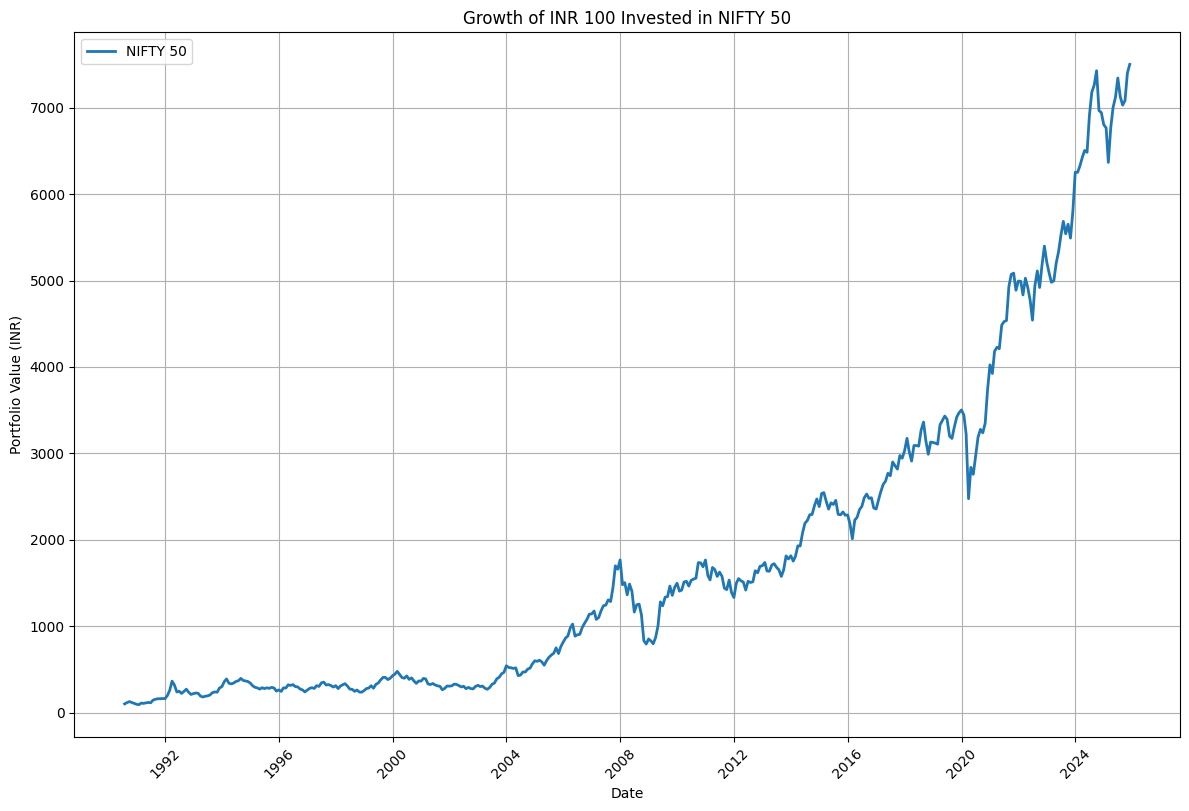

In [1458]:
initial_value = 100

market_data['Return'] = market_data['^NSEI'].pct_change()
market_data['Portfolio'] = initial_value * (1 + market_data['Return']).cumprod()
market_data['Portfolio'].iloc[0] = initial_value

# Assuming 'portfolios' dictionary has the portfolios for each factor with 'Date' and 'Portfolio_Value'

# Step 1: Plotting the growth of portfolios for each factor
plt.figure(figsize=(12, 8))

# Plot the portfolio value over time
plt.plot(market_data.index, market_data['Portfolio'], label='NIFTY 50', linewidth = 2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.title('Growth of INR 100 Invested in NIFTY 50')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Create Next Month Return Column

In [1459]:
market_data['next_month_return'] = market_data['Return'].shift(-1)
market_data.head()

,^NSEI,Return,Portfolio,next_month_return
Date,,,,
1990-07-31,347.44,NaN,100.000000,0.151451
1990-08-31,400.06,0.151451,115.145061,0.099135
1990-09-30,439.72,0.099135,126.559982,-0.082007
1990-10-31,403.66,-0.082007,116.181211,-0.089110
1990-11-30,367.69,-0.089110,105.828344,-0.100166


In [1460]:
features_df_list = []


## Adding Idiosyncratic Features

### 1. Momentum

In [1461]:
market_data['momentum_1_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(1) - 1
market_data['momentum_3_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(3) - 1
market_data['momentum_6_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(6) - 1


market_data.head(13)

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1
Date,,,,,,,
1990-07-31,347.44,NaN,100.000000,0.151451,NaN,NaN,NaN
1990-08-31,400.06,0.151451,115.145061,0.099135,0.151451,NaN,NaN
1990-09-30,439.72,0.099135,126.559982,-0.082007,0.099135,NaN,NaN
1990-10-31,403.66,-0.082007,116.181211,-0.089110,-0.082007,0.161812,NaN
1990-11-30,367.69,-0.089110,105.828344,-0.100166,-0.089110,-0.080913,NaN
1990-12-31,330.86,-0.100166,95.227953,-0.049870,-0.100166,-0.247567,NaN
1991-01-31,314.36,-0.049870,90.478932,0.208614,-0.049870,-0.221226,-0.095211
1991-02-28,379.94,0.208614,109.354133,-0.035506,0.208614,0.033316,-0.050292
1991-03-31,366.45,-0.035506,105.471448,0.061564,-0.035506,0.107568,-0.166629


### 2. Sensex P/E

In [1462]:
sheet_id = "1ZcT4v4PzjwACcbzmwYXGwxLMRXtuQGwsSEPyONMcfcU"
sheet_name = "Sheet1"  # or your specific sheet name

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

cape = pd.read_csv(url)
cape['Date'] = pd.to_datetime(cape['Date'])
cape = cape.set_index('Date').resample('ME').last()

features_df_list.append(cape[['P/E']])
display(cape.head())
# market_data = pd.merge(market_data,cape['BSE Sensex CAPE 5'], left_index=True, right_index=True, how='left')
# market_data.head()

,BSE Sensex CAPE 5,Sensex Close Price,P/E,EPS,Inflation Rate,Inflation Adjusted EPS,Inflation Adjusted Price,Last 120 Month EPS Inflation Adj
Date,,,,,,,,
1995-04-30,35.67,3133.28,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-31,33.25,3351.48,NaN,NaN,NaN,NaN,NaN,NaN
1995-06-30,33.69,3247.36,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-31,32.58,3386.97,NaN,NaN,NaN,NaN,NaN,NaN
1995-08-31,32.55,3346.76,NaN,NaN,NaN,NaN,NaN,NaN


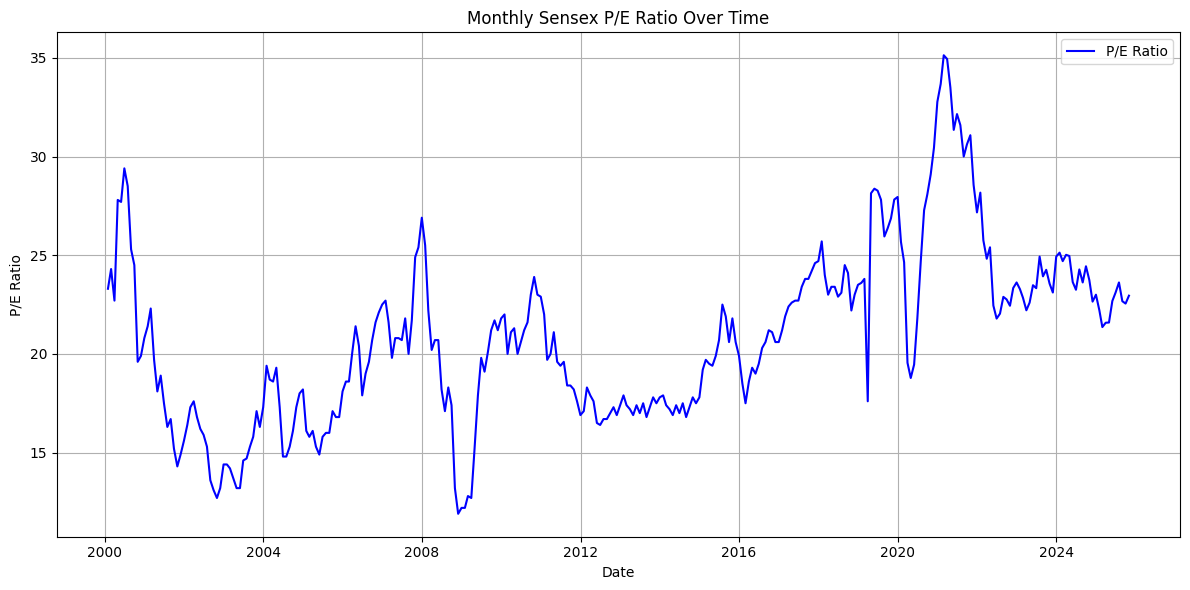

In [1463]:
plt.figure(figsize=(12,6))
plt.plot(cape.index, cape['P/E'], label='P/E Ratio', color='blue')
plt.xlabel('Date')
plt.ylabel('P/E Ratio')
plt.title('Monthly Sensex P/E Ratio Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Low Risk Factor

In [1464]:
low_risk = pd.read_csv("./data/[ind]_[low_risk]_[monthly]_[vw_cap].csv")
low_risk = low_risk[['date', 'ret']]
low_risk["date"] = pd.to_datetime(low_risk["date"])
low_risk = low_risk.set_index("date")
low_risk = low_risk.rename(columns={
    "ret":"low_risk"
})

features_df_list.append(low_risk[['low_risk']])

low_risk.tail()

,low_risk
date,
2024-08-31,0.010172
2024-09-30,0.014639
2024-10-31,-0.001784
2024-11-30,-0.018924
2024-12-31,-0.007749


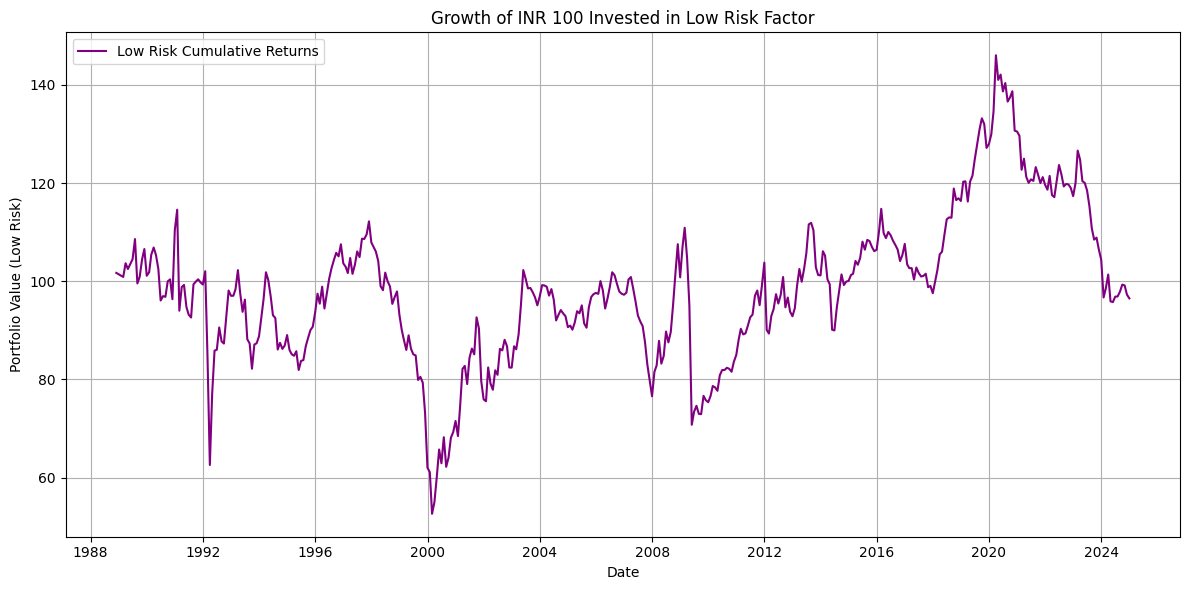

In [1465]:
initial_value = 100
low_risk_cumm = initial_value * (1 + low_risk['low_risk'].fillna(0)).cumprod()
plt.figure(figsize=(12,6))
plt.plot(low_risk.index, low_risk_cumm, label='Low Risk Cumulative Returns', color='purple')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Low Risk)')
plt.title('Growth of INR 100 Invested in Low Risk Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Momentum Factor

In [1466]:
momentum = pd.read_csv("./data/[ind]_[momentum]_[monthly]_[vw_cap].csv")
momentum = momentum[['date', 'ret']]
momentum["date"] = pd.to_datetime(momentum["date"])
momentum = momentum.set_index("date")
momentum = momentum.rename(columns={"ret": "momentum"})

features_df_list.append(momentum[['momentum']])

momentum.tail()

,momentum
date,
2024-08-31,-0.002884
2024-09-30,-0.009180
2024-10-31,0.004541
2024-11-30,0.011476
2024-12-31,0.027236


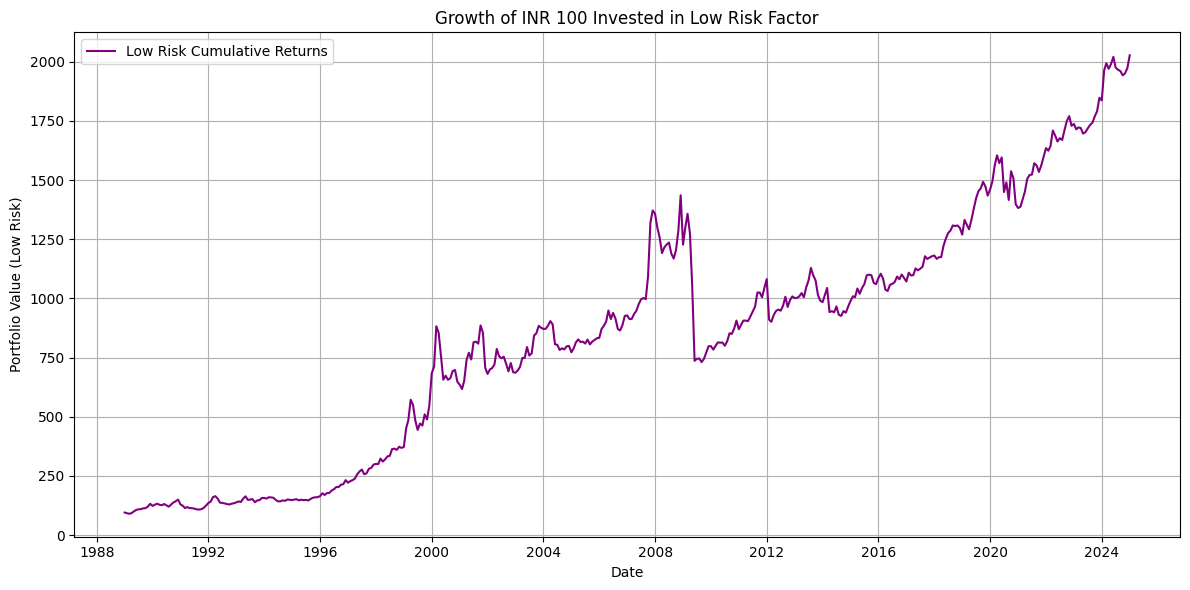

In [1467]:
initial_value = 100
momentum_cumm = initial_value * (1 + momentum['momentum'].fillna(0)).cumprod()
plt.figure(figsize=(12,6))
plt.plot(momentum.index, momentum_cumm, label='Low Risk Cumulative Returns', color='purple')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Low Risk)')
plt.title('Growth of INR 100 Invested in Low Risk Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Macro Economic Features

### 1. Inflation

In [1468]:
# Step 2: Initialize the FRED API with your API key
# (Get one for free from https://fred.stlouisfed.org/docs/api/api_key.html)
fred = Fred(api_key='8b995803b3d5488cc5f5dcaaedb698ff')

# # Step 3: Fetch the data
# series_id = 'INDCPIALLMINMEI'
# inflation_data = fred.get_series(series_id)

# # Step 4: Convert to DataFrame for easier handling
# inflation_df = pd.DataFrame(inflation_data, columns=['CPI'])
# inflation_df.index.name = 'Date'

# inflation_df = inflation_df.resample('ME').last()
# inflation_df['inflation_rate'] = inflation_df['CPI'].pct_change()

inflation_df = pd.read_csv('data/india_inflation.csv')
inflation_df['Date'] = pd.to_datetime(inflation_df['Date'])
inflation_df = inflation_df.set_index('Date')

features_df_list.append(inflation_df[['inflation_rate']])
display(inflation_df.tail())
# market_data = pd.merge(market_data,inflation_df[['inflation_rate']], left_index=True, right_index=True, how='left')
# market_data.head()

,CPI,inflation_rate
Date,,
2025-06-30,0.0,0.021
2025-07-31,0.0,0.016
2025-08-31,0.0,0.021
2025-09-30,0.0,0.014
2025-10-31,0.0,0.003


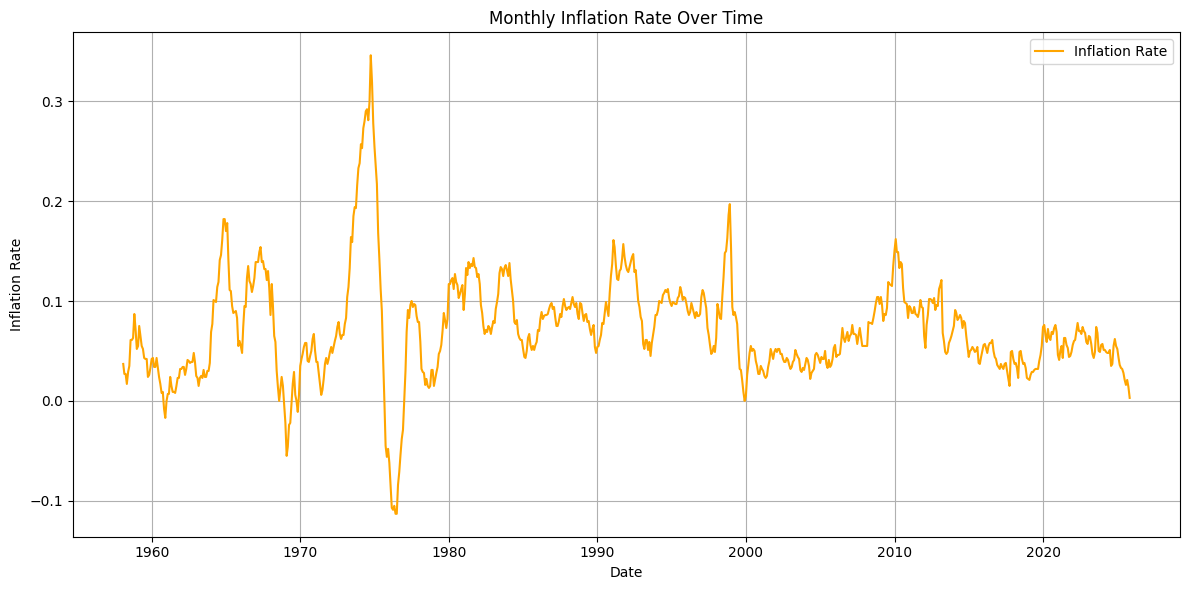

In [1469]:
# Plot inflation_rate line chart
plt.figure(figsize=(12,6))
plt.plot(inflation_df.index, inflation_df['inflation_rate'], label='Inflation Rate', color='orange')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')
plt.title('Monthly Inflation Rate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (4) - Interest Rates

In [1470]:
# Step 3: Fetch the data
series_id = 'IRSTCI01INM156N'
interest_rate_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
interest_rate_df = pd.DataFrame(interest_rate_data, columns=['Interest_Rate'])
interest_rate_df.index.name = 'Date'

interest_rate_df = interest_rate_df.resample('ME').last()

features_df_list.append(interest_rate_df)
display(interest_rate_df.tail())
# market_data = pd.merge(market_data,interest_rate_df, left_index=True, right_index=True, how='left')
# market_data.head()

,Interest_Rate
Date,
2025-06-30,5.75
2025-07-31,5.75
2025-08-31,5.75
2025-09-30,5.75
2025-10-31,5.75


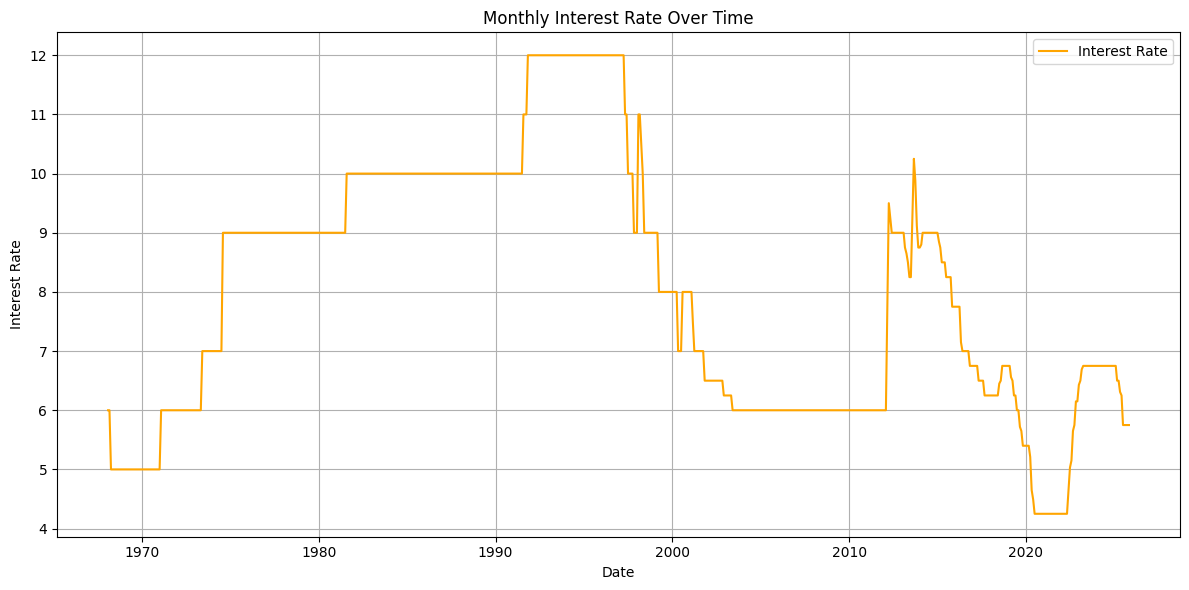

In [1471]:
# Plot inflation_rate line chart
plt.figure(figsize=(12,6))
plt.plot(interest_rate_df.index, interest_rate_df['Interest_Rate'], label='Interest Rate', color='orange')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Monthly Interest Rate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (5) - USD / INR Exchange Rate

In [1472]:
series_id = 'DEXINUS'
usd_inr_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
usd_inr_data_df = pd.DataFrame(usd_inr_data, columns=['USDINR=X'])
usd_inr_data_df.index.name = 'Date'
usd_inr_data_df = usd_inr_data_df.resample('ME').last()


ticker = 'USDINR=X'
# Download data
start_date = usd_inr_data_df.index[-1] + MonthEnd(1)
usd_inr = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
usd_inr = usd_inr[['Close']]
usd_inr = usd_inr.resample('ME').last()

usd_inr = pd.concat([usd_inr_data_df,usd_inr['Close']], axis=0)
usd_inr.head()

features_df_list.append(usd_inr)
display(usd_inr.tail())
# market_data = pd.merge(market_data,usd_inr, left_index=True, right_index=True, how='left')
# market_data.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['USDINR=X']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-12-31 00:00:00 -> 2025-11-22) (Yahoo error = "Invalid input - start date cannot be after end date. startDate = 1767139200, endDate = 1763769600")')


,USDINR=X
Date,
2025-07-31,87.60
2025-08-31,88.18
2025-09-30,88.78
2025-10-31,88.75
2025-11-30,88.74


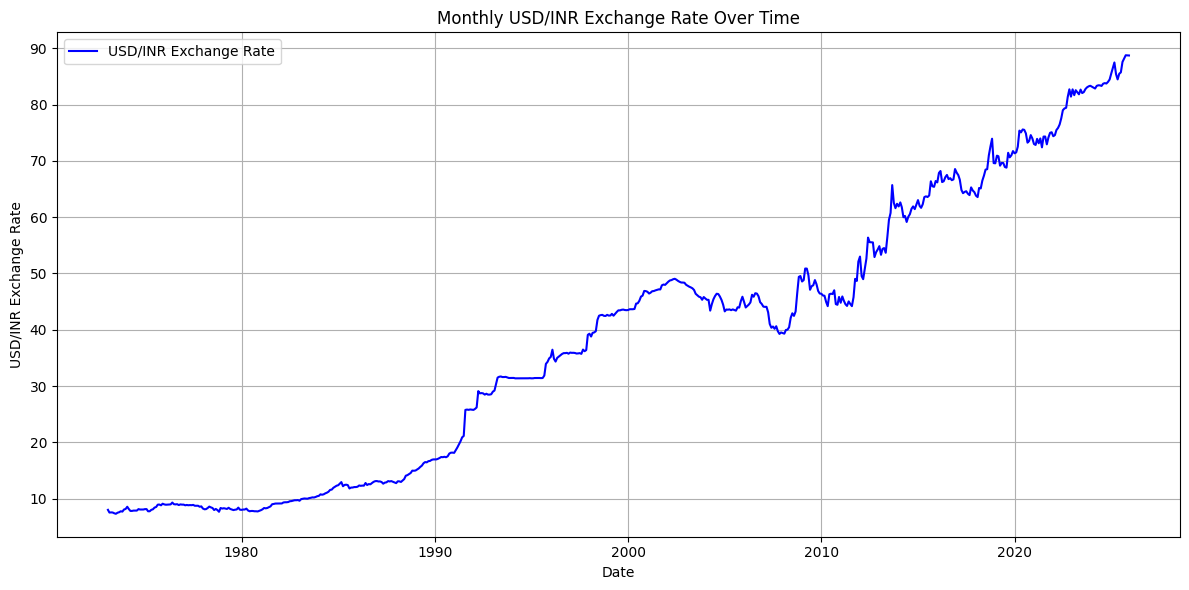

In [1473]:
# Plot USDINR=X exchange rate over time
plt.figure(figsize=(12,6))
plt.plot(usd_inr.index, usd_inr['USDINR=X'], label='USD/INR Exchange Rate', color='blue')
plt.xlabel('Date')
plt.ylabel('USD/INR Exchange Rate')
plt.title('Monthly USD/INR Exchange Rate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (6) - Global Equity - MSCI World

In [1474]:
ticker = '^990100-USD-STRD'
# Download data
start_date = market_data.index[0]
world_equity = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
world_equity = pd.DataFrame(world_equity['Close'])
world_equity.rename(columns = {'^990100-USD-STRD': 'World_Equity'}, inplace=True)
world_equity = world_equity.resample('ME').last()

features_df_list.append(world_equity)
display(world_equity.tail())
# market_data = pd.merge(market_data,world_equity, left_index=True, right_index=True, how='left')
# market_data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,World_Equity
Date,
2025-07-31,4076.000000
2025-08-31,4177.700195
2025-09-30,4306.700195
2025-10-31,4390.399902
2025-11-30,4242.700195


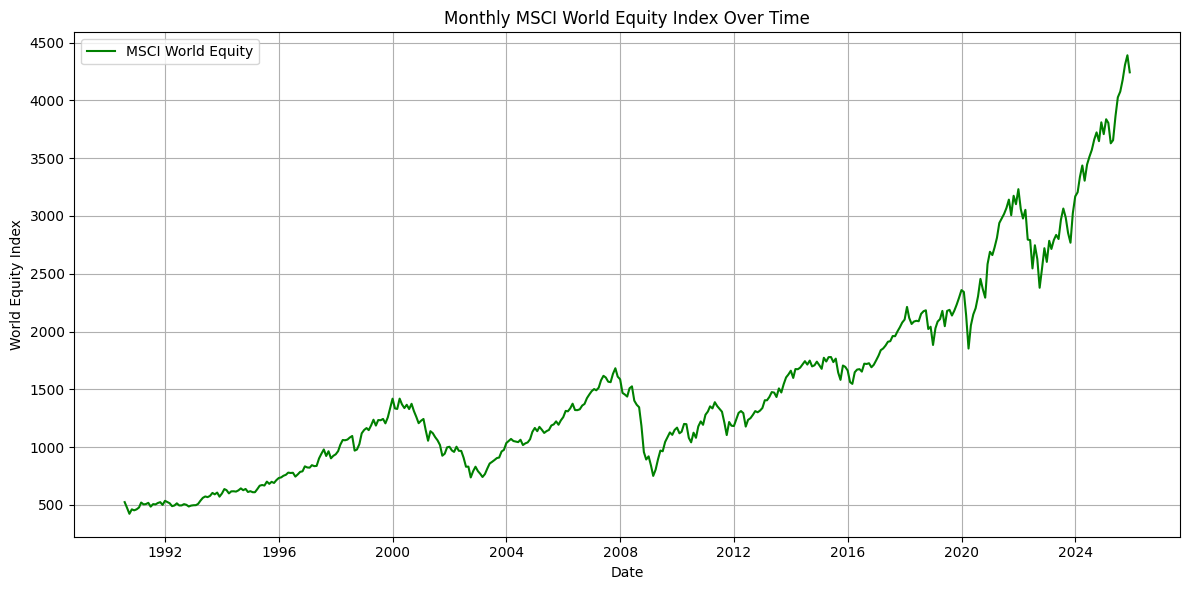

In [1475]:
# Plot World_Equity over time
plt.figure(figsize=(12,6))
plt.plot(world_equity.index, world_equity['World_Equity'], label='MSCI World Equity', color='green')
plt.xlabel('Date')
plt.ylabel('World Equity Index')
plt.title('Monthly MSCI World Equity Index Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (7) - Leading Composite Index

In [1476]:
import requests
import pandas as pd
from io import StringIO

# Define API query URL (example for CSV with labels format)
# This URL is an example and would need to be adapted based on your specific data selection in the OECD Data Explorer.
url = "https://sdmx.oecd.org/public/rest/data/OECD.SDD.STES,DSD_STES@DF_CLI,/IND.M.LI...AA...H?dimensionAtObservation=AllDimensions&format=csvfilewithlabels"

# Fetch data
response = requests.get(url)
response.raise_for_status() # Raise an exception for bad status codes

# print(response.text)  # Print the first 500 characters of the response for inspection

# Read the CSV data into a pandas DataFrame
leading_composite_index_df = pd.read_csv(StringIO(response.text))
leading_composite_index_df = leading_composite_index_df[['TIME_PERIOD','OBS_VALUE']].set_index('TIME_PERIOD')
leading_composite_index_df.index = pd.to_datetime(leading_composite_index_df.index)
leading_composite_index_df = leading_composite_index_df.resample('ME').last()

# Display the first few rows of the DataFrame
display(leading_composite_index_df.tail())

features_df_list.append(leading_composite_index_df)
# market_data = pd.merge(market_data,leading_composite_index_df, left_index=True, right_index=True, how='left')
# market_data.tail()

,OBS_VALUE
TIME_PERIOD,
2025-06-30,100.4054
2025-07-31,100.4807
2025-08-31,100.5563
2025-09-30,100.6329
2025-10-31,100.7116


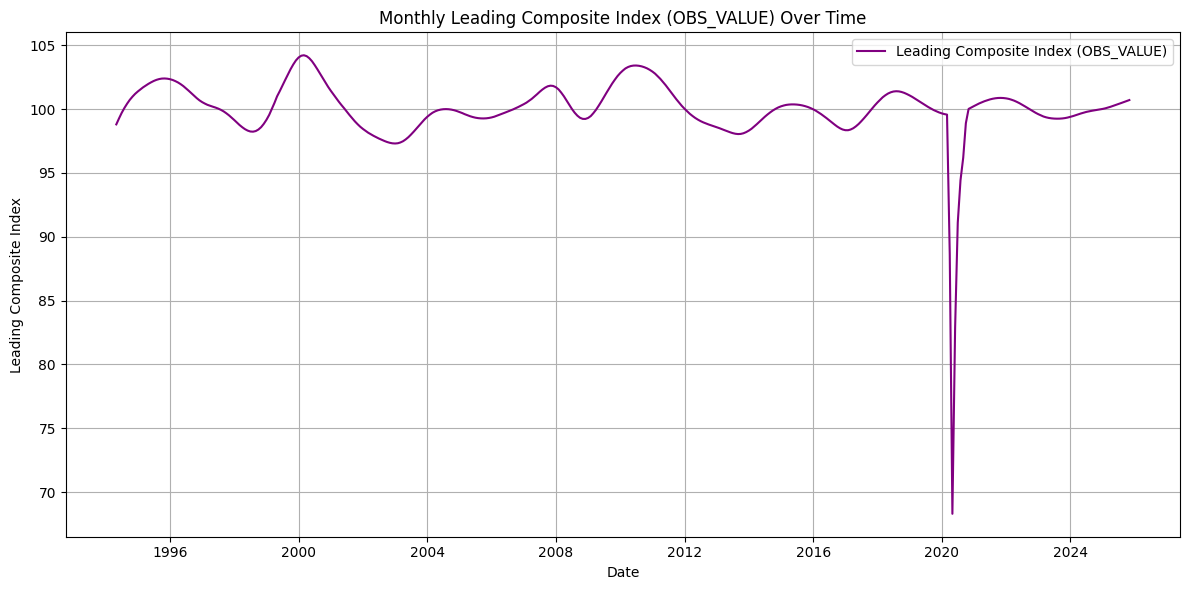

In [1477]:
# Plot OBS_VALUE (Leading Composite Index) over time
plt.figure(figsize=(12,6))
plt.plot(leading_composite_index_df.index, leading_composite_index_df['OBS_VALUE'], label='Leading Composite Index (OBS_VALUE)', color='purple')
plt.xlabel('Date')
plt.ylabel('Leading Composite Index')
plt.title('Monthly Leading Composite Index (OBS_VALUE) Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Adding Features (8) - Nominal GDP

In [1478]:
# series_id = 'NGDPNSAXDCINQ' #Nominal Gross Domestic Product for India
# gdp_data = fred.get_series(series_id)

# # Step 4: Convert to DataFrame for easier handling
# gdp_data_df = pd.DataFrame(gdp_data, columns=['GDP'])
# gdp_data_df.index.name = 'Date'
# gdp_data_df = gdp_data_df.resample('ME').last().ffill()

# features_df_list.append(gdp_data_df)
# display(gdp_data_df.tail())

# gdp_data.to_csv('data/india_gdp.csv')

gdp_data_df = pd.read_csv('data/india_gdp.csv')
gdp_data_df['Date'] = pd.to_datetime(gdp_data_df['Date'], format="%d-%m-%Y")
gdp_data_df['Date'] = pd.to_datetime(gdp_data_df['Date']) - pd.Timedelta(days=1)
gdp_data_df = gdp_data_df.set_index('Date')
gdp_data_df = gdp_data_df.resample('ME').last().ffill()

features_df_list.append(gdp_data_df[['Nominal GDP']])
display(gdp_data_df.tail(20))

,Nominal GDP
Date,
2024-03-31,79609657.0
2024-04-30,79609657.0
2024-05-31,79609657.0
2024-06-30,79078942.1
2024-07-31,79078942.1
2024-08-31,79078942.1
2024-09-30,78403450.8
2024-10-31,78403450.8
2024-11-30,78403450.8


In [1479]:
# Plot GDP over time
plt.figure(figsize=(12,6))
plt.plot(market_data.index, market_data['Nominal GDP'], label='GDP', color='red')
plt.xlabel('Date')
plt.ylabel('GDP (INR)')
plt.title('Monthly GDP Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'Nominal GDP'

<Figure size 1200x600 with 0 Axes>

### 10. FPI Inflows

In [ ]:
fpi_inflows = pd.read_excel("./data/fpi_inflows.xlsx")
fpi_inflows["Date"] = pd.to_datetime(fpi_inflows["Date"])
fpi_inflows = fpi_inflows.set_index("Date")

features_df_list.append(fpi_inflows[['FPI_Inflow']])

fpi_inflows.tail()

,FPI_Inflow
Date,
2025-06-30,-17740.58
2025-07-31,-34993.43
2025-08-31,-23884.72
2025-09-30,14610.31
2025-10-31,-3788.49


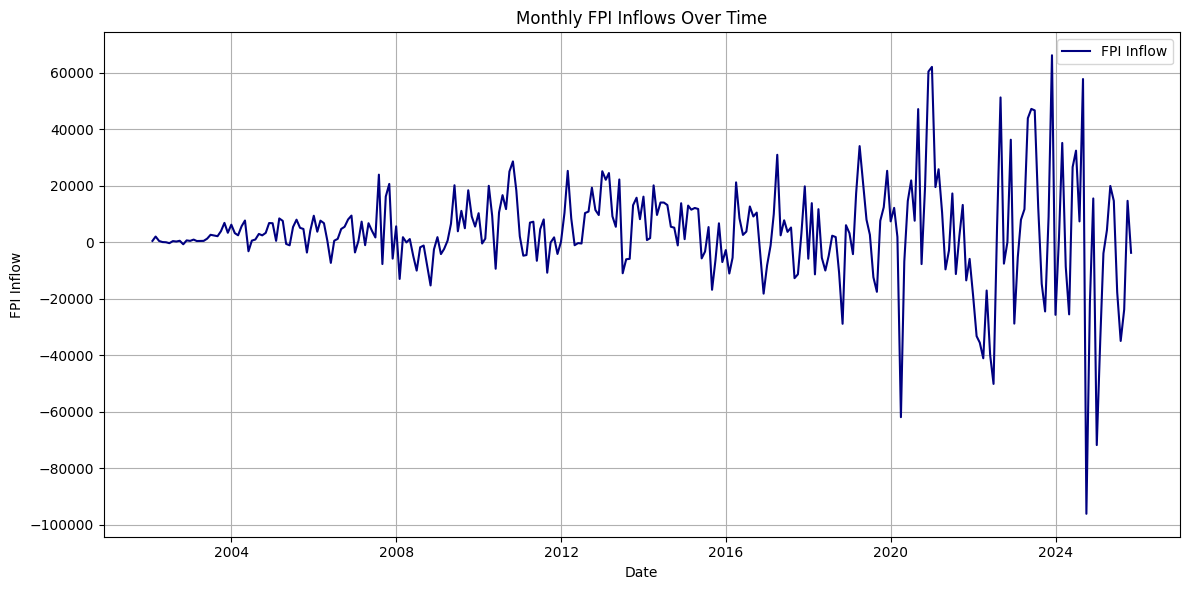

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(fpi_inflows.index, fpi_inflows['FPI_Inflow'], label='FPI Inflow', color='navy')
plt.xlabel('Date')
plt.ylabel('FPI Inflow')
plt.title('Monthly FPI Inflows Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Sentiment Features

### Adding Features (9) - Investor Sentiment (Ticker Tape)

In [ ]:
# Read Market Mood Index data
market_mood_df = pd.read_csv("./data/MMI_2025-11-16.csv")

# Convert Date column to datetime with DD/MM/YYYY format
market_mood_df['Date'] = pd.to_datetime(market_mood_df['Date'], format='%d/%m/%Y')

# Set Date as index and select only Market Mood Index column
market_mood_df = market_mood_df.set_index('Date')

# Resample to month-end
market_mood_df = market_mood_df.resample('ME').last()
market_mood_df.columns = ['Market_Mood_Index', 'NIFTY']
market_mood_df = market_mood_df[['Market_Mood_Index']]

# Add to features_df_list
features_df_list.append(market_mood_df)

display(market_mood_df.tail())

,Market_Mood_Index
Date,
2025-07-31,32.641974
2025-08-31,24.846767
2025-09-30,48.485552
2025-10-31,68.686544
2025-11-30,56.910493


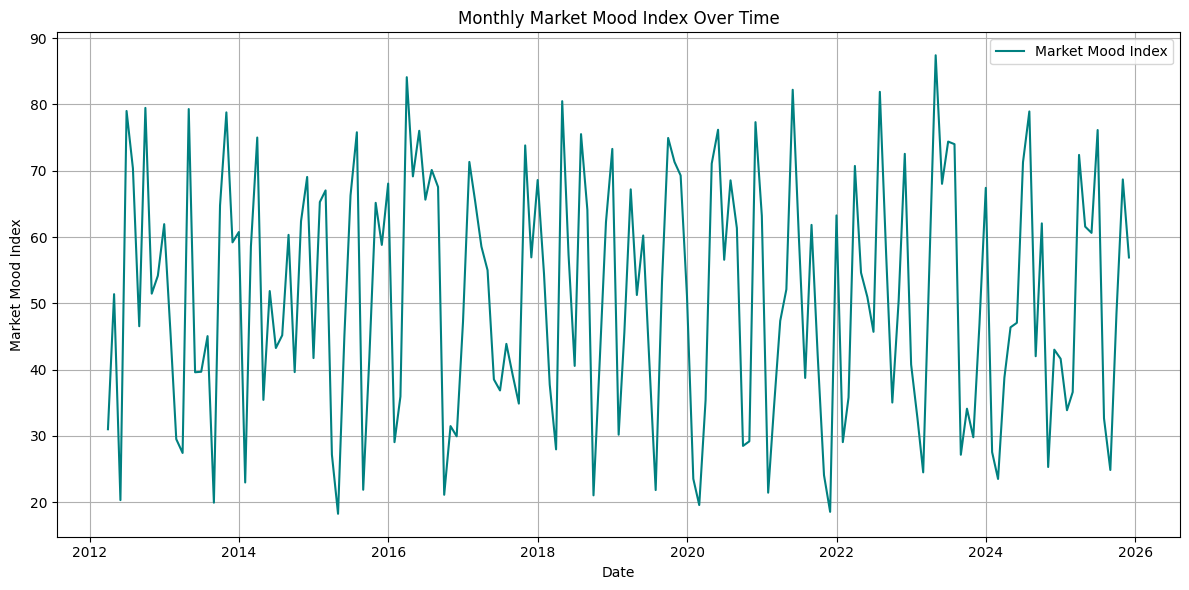

In [ ]:
# Plot Market Mood Index over time
plt.figure(figsize=(12,6))
plt.plot(market_mood_df.index, market_mood_df['Market_Mood_Index'], label='Market Mood Index', color='teal')
plt.xlabel('Date')
plt.ylabel('Market Mood Index')
plt.title('Monthly Market Mood Index Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Merging dataframes and putting all features together

In [ ]:
for feature_df in features_df_list:
    print(
        f"{feature_df.columns[0]}: Start Date = {feature_df.index.min().strftime('%Y-%m-%d')}, "
        f"End Date = {feature_df.index.max().strftime('%Y-%m-%d')}"
    )
    market_data = pd.merge(market_data, feature_df, left_index=True, right_index=True, how='left')



P/E: Start Date = 1995-04-30, End Date = 2025-10-31
low_risk: Start Date = 1988-11-30, End Date = 2024-12-31
momentum: Start Date = 1988-12-31, End Date = 2024-12-31
inflation_rate: Start Date = 1957-01-31, End Date = 2025-10-31
Interest_Rate: Start Date = 1968-01-31, End Date = 2025-10-31
USDINR=X: Start Date = 1973-01-31, End Date = 2025-11-30
World_Equity: Start Date = 1990-07-31, End Date = 2025-11-30
OBS_VALUE: Start Date = 1994-04-30, End Date = 2025-10-31
Nominal GDP: Start Date = 2004-03-31, End Date = 2025-10-31
Market_Mood_Index: Start Date = 2012-03-31, End Date = 2025-11-30


In [ ]:
market_data['Nominal GDP'] = market_data['^NSEI']/market_data['Nominal GDP'] #market cap to GDP ratio

# Use pct change where needed
market_data['USDINR=X'] = market_data['USDINR=X'].pct_change()
market_data['World_Equity'] = market_data['World_Equity'].pct_change()
market_data['P/E'] = market_data['P/E'].pct_change()

market_data.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,P/E,low_risk,momentum,inflation_rate,Interest_Rate,USDINR=X,World_Equity,OBS_VALUE,Nominal GDP,Market_Mood_Index
Date,,,,,,,,,,,,,,,,,
1990-07-31,347.44,NaN,100.000000,0.151451,NaN,NaN,NaN,NaN,0.009368,-0.046636,0.099,10.0,NaN,NaN,NaN,NaN,NaN
1990-08-31,400.06,0.151451,115.145061,0.099135,0.151451,NaN,NaN,NaN,-0.001512,0.076490,0.092,10.0,0.009798,-0.095574,NaN,NaN,NaN
1990-09-30,439.72,0.099135,126.559982,-0.082007,0.099135,NaN,NaN,NaN,0.032534,0.067227,0.085,10.0,0.027397,-0.107572,NaN,NaN,NaN
1990-10-31,403.66,-0.082007,116.181211,-0.089110,-0.082007,0.161812,NaN,NaN,0.004055,0.039461,0.108,10.0,0.008889,0.090995,NaN,NaN,NaN
1990-11-30,367.69,-0.089110,105.828344,-0.100166,-0.089110,-0.080913,NaN,NaN,-0.040276,0.046282,0.125,10.0,0.000551,-0.018414,NaN,NaN,NaN


### Create separate dataframes for macro, sentiment, and idiosyncratic

In [ ]:
macro_columns = ['inflation_rate']
macro_columns_2 = ['USDINR=X', 'FPI_Inflow']
macro_columns_3 = ['World_Equity', 'Nominal GDP']
sentiment_columns = ['Market_Mood_Index']
idiosyncratic_columns = ['momentum_1_1','momentum_6_1', 'P/E']

In [ ]:
market_data_macro = market_data[macro_columns + ['next_month_return']]
market_data_macro_2 = market_data[macro_columns_2 + ['next_month_return']]
market_data_macro_3 = market_data[macro_columns_3 + ['next_month_return']]
market_data_sentiment = market_data[sentiment_columns + ['next_month_return']]
market_data_idiosyncratic = market_data[idiosyncratic_columns + ['next_month_return']]

KeyError: "['FPI_Inflow'] not in index"

In [ ]:
market_data_macro = market_data_macro["2000-01-31":]
market_data_macro = market_data_macro.dropna()
market_data_macro.tail()

,inflation_rate,next_month_return
Date,,
2025-06-30,0.021,-0.029341
2025-07-31,0.016,-0.013788
2025-08-31,0.021,0.007543
2025-09-30,0.014,0.045142
2025-10-31,0.003,0.018274


In [ ]:
market_data_macro_2 = market_data_macro_2.dropna()
market_data_macro_2.tail()

,USDINR=X,FPI_Inflow,next_month_return
Date,,,
2025-06-30,0.002807,-17740.58,-0.029341
2025-07-31,0.021693,-34993.43,-0.013788
2025-08-31,0.006621,-23884.72,0.007543
2025-09-30,0.006804,14610.31,0.045142
2025-10-31,-0.000338,-3788.49,0.018274


In [ ]:
market_data_macro_3 = market_data_macro_3.dropna()
market_data_macro_3.tail()

,World_Equity,Nominal GDP,next_month_return
Date,,,
2025-06-30,0.042164,0.000297,-0.029341
2025-07-31,0.012319,0.000288,-0.013788
2025-08-31,0.024951,0.000284,0.007543
2025-09-30,0.030878,0.000286,0.045142
2025-10-31,0.019435,0.000299,0.018274


In [ ]:
market_data_sentiment = market_data_sentiment.dropna()
market_data_sentiment.tail()

,Market_Mood_Index,next_month_return
Date,,
2025-06-30,76.140202,-0.029341
2025-07-31,32.641974,-0.013788
2025-08-31,24.846767,0.007543
2025-09-30,48.485552,0.045142
2025-10-31,68.686544,0.018274


In [ ]:
market_data_idiosyncratic = market_data_idiosyncratic.dropna()
market_data_idiosyncratic.tail()

,momentum_1_1,momentum_6_1,P/E,next_month_return
Date,,,,
2025-06-30,0.030963,0.079182,0.018959,-0.029341
2025-07-31,-0.029341,0.053596,0.022068,-0.013788
2025-08-31,-0.013788,0.104053,-0.040220,0.007543
2025-09-30,0.007543,0.046419,-0.005293,0.045142
2025-10-31,0.045142,0.057035,0.017738,0.018274


## Visualization

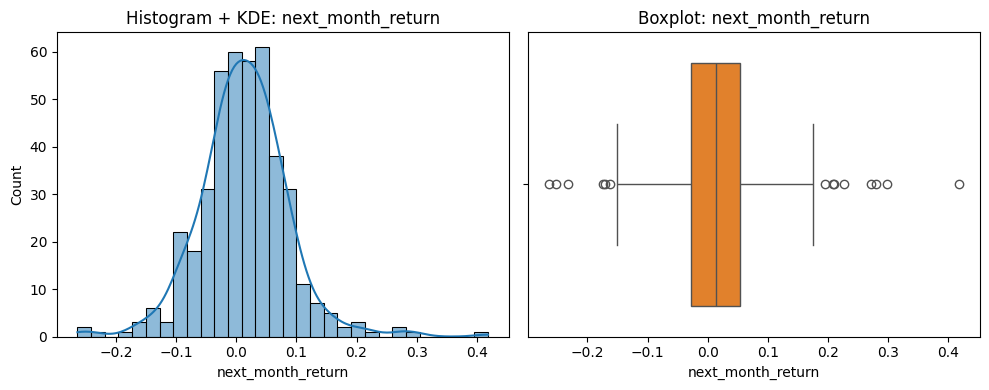

In [ ]:
col = 'next_month_return'
data = market_data[col]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))

# Histogram with KDE
plt.subplot(1,2,1)
sns.histplot(data, bins=30, kde=True, color='C0')
plt.title(f'Histogram + KDE: {col}')
plt.xlabel(col)
plt.ylabel('Count')

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=data, color='C1')
plt.title(f'Boxplot: {col}')
plt.xlabel(col)

plt.tight_layout()
plt.show()

## Pre-Processing 

In [ ]:
return_threshold = market_data_macro['next_month_return'].quantile(0.25)
return_threshold

np.float64(-0.022712435930456937)

In [ ]:
# Create the 'positive_returns' column

bins = [-np.inf,return_threshold, np.inf]
labels = [0, 1]

market_data_macro['regime'] = pd.cut(
    market_data_macro['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

market_data_macro_2['regime'] = pd.cut(
    market_data_macro_2['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

market_data_macro_3['regime'] = pd.cut(
    market_data_macro_3['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

market_data_sentiment['regime'] = pd.cut(
    market_data_sentiment['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

market_data_idiosyncratic['regime'] = pd.cut(
    market_data_idiosyncratic['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

## Random Forest Classifiers

We will create three random forest classifiers - macro, sentiment, and idiosyncratic. Then we will combine the outputs of these three classifiers to get the final regime classification  output

### Macro Classifier

In [ ]:
from itertools import combinations

train_test_split = 0.80

# assume z_score_columns already exists
# feature_pairs = list(combinations(z_score_columns, 1))            # list of tuples

split_of_date_to_use = round(train_test_split*len(market_data_macro))
# Features and target variable
# for feature_pair in feature_pairs:
# print(feature_pair)
X = market_data_macro[macro_columns].iloc[:split_of_date_to_use]
y = market_data_macro['regime'].iloc[:split_of_date_to_use]

# Initialize the Random Forest Classifier
clf_macro = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_macro = cross_val_score(clf_macro, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_macro.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))

# Output results
print(f"Cross-Validation Scores: {cv_scores_macro}")
print(f"Mean Accuracy: {np.mean(cv_scores_macro):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_macro):.4f}")

last_training_date = X.index[-1].date()

Trainign from date 2000-01-31 to 2020-08-31
Cross-Validation Scores: [0.66       0.64       0.42       0.67346939 0.57142857]
Mean Accuracy: 0.5930
Standard Deviation: 0.0933


### Macro Classifier 2

In [ ]:
# Features and target variable
# for feature_pair in feature_pairs:
# print(feature_pair)
X = market_data_macro_2[macro_columns_2].loc[:last_training_date]
y = market_data_macro_2['regime'].loc[:last_training_date]

# Initialize the Random Forest Classifier
clf_macro_2 = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_macro_2 = cross_val_score(clf_macro_2, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_macro_2.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))
# Output results
print(f"Cross-Validation Scores: {cv_scores_macro_2}")
print(f"Mean Accuracy: {np.mean(cv_scores_macro_2):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_macro_2):.4f}")

Trainign from date 2002-01-31 to 2020-08-31
Cross-Validation Scores: [0.62222222 0.64444444 0.57777778 0.66666667 0.56818182]
Mean Accuracy: 0.6159
Standard Deviation: 0.0378


### Macro Classifer 3

In [ ]:
# Features and target variable
# for feature_pair in feature_pairs:
# print(feature_pair)
X = market_data_macro_3[macro_columns_3].loc[:last_training_date]
y = market_data_macro_3['regime'].loc[:last_training_date]

# Initialize the Random Forest Classifier
clf_macro_3 = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_macro_3 = cross_val_score(clf_macro_3, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_macro_3.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))
# Output results
print(f"Cross-Validation Scores: {cv_scores_macro_3}")
print(f"Mean Accuracy: {np.mean(cv_scores_macro_3):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_macro_3):.4f}")

Trainign from date 2004-06-30 to 2020-08-31
Cross-Validation Scores: [0.56410256 0.56410256 0.64102564 0.66666667 0.74358974]
Mean Accuracy: 0.6359
Standard Deviation: 0.0676


### Sentiment Classifier

In [ ]:
X = market_data_sentiment[sentiment_columns].loc[:last_training_date]
y = market_data_sentiment['regime'].loc[:last_training_date]

# Initialize the Random Forest Classifier
clf_sentiment = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_sentiment = cross_val_score(clf_sentiment, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_sentiment.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))
# Output results
print(f"Cross-Validation Scores: {cv_scores_sentiment}")
print(f"Mean Accuracy: {np.mean(cv_scores_sentiment):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_sentiment):.4f}")

Trainign from date 2012-03-31 to 2020-08-31
Cross-Validation Scores: [0.61904762 0.57142857 0.65       0.6        0.6       ]
Mean Accuracy: 0.6081
Standard Deviation: 0.0259


### Technical Classifier

In [ ]:
X = market_data_idiosyncratic[idiosyncratic_columns].loc[:last_training_date]
y = market_data_idiosyncratic['regime'].loc[:last_training_date]

# Initialize the Random Forest Classifier
clf_idiosyncratic = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores_idiosyncratic = cross_val_score(clf_idiosyncratic, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf_idiosyncratic.fit(X, y)

print("Trainign from date {} to {}".format(X.index[0].date(), X.index[-1].date()))
# Output results
print(f"Cross-Validation Scores: {cv_scores_idiosyncratic}")
print(f"Mean Accuracy: {np.mean(cv_scores_idiosyncratic):.4f}")
print(f"Standard Deviation: {np.std(cv_scores_idiosyncratic):.4f}")

Trainign from date 2000-02-29 to 2020-08-31
Cross-Validation Scores: [0.6        0.56       0.67346939 0.65306122 0.63265306]
Mean Accuracy: 0.6238
Standard Deviation: 0.0401


## Combining output on Test Data

In [ ]:
X = market_data_macro[macro_columns].iloc[split_of_date_to_use:]
y_macro = market_data_macro['regime'].iloc[split_of_date_to_use:]
macro_classifier_output = clf_macro.predict(X)

X = market_data_macro_2[macro_columns_2].loc[y_macro.index[0]:y_macro.index[-1]]
y_sentiment = market_data_macro_2['regime'].loc[y_macro.index[0]:y_macro.index[-1]]
macro_classifier_output_2 = clf_macro_2.predict(X)

X = market_data_macro_3[macro_columns_3].loc[y_macro.index[0]:y_macro.index[-1]]
y_sentiment = market_data_macro_3['regime'].loc[y_macro.index[0]:y_macro.index[-1]]
macro_classifier_output_3 = clf_macro_3.predict(X)

X = market_data_sentiment[sentiment_columns].loc[y_macro.index[0]:y_macro.index[-1]]
y_sentiment = market_data_sentiment['regime'].loc[y_macro.index[0]:y_macro.index[-1]]
sentiment_classifier_output = clf_sentiment.predict(X)

X = market_data_idiosyncratic[idiosyncratic_columns].loc[y_macro.index[0]:y_macro.index[-1]]
y_idiosyncratic = market_data_idiosyncratic['regime'].loc[y_macro.index[0]:y_macro.index[-1]]
idiosyncratic_classifier_output = clf_idiosyncratic.predict(X)

print("Prediction From {} to {}".format(y_macro.index[0].strftime('%Y-%m-%d'), y_macro.index[-1].strftime('%Y-%m-%d')))

Prediction From 2020-09-30 to 2025-10-31


In [ ]:
print("Length of macro_classifier_output:", len(macro_classifier_output))
print("Length of macro_classifier_output_2:", len(macro_classifier_output_2))
print("Length of macro_classifier_output_3:", len(macro_classifier_output_3))
print("Length of sentiment_classifier_output:", len(sentiment_classifier_output))
print("Length of idiosyncratic_classifier_output:", len(idiosyncratic_classifier_output))

test_output_df = pd.DataFrame({
    'Actual_Regime': y_macro,
    'Macro_Predicted_Regime': macro_classifier_output,
    'Macro Predicted_Regime 2': macro_classifier_output_2,
    'Macro Predicted_Regime 3': macro_classifier_output_3,
    'Sentiment_Predicted_Regime': sentiment_classifier_output,
    'Idiosyncratic_Predicted_Regime': idiosyncratic_classifier_output
})

test_output_df['Predicted_Regime'] = test_output_df[['Macro Predicted_Regime 2','Macro Predicted_Regime 3','Sentiment_Predicted_Regime', 'Idiosyncratic_Predicted_Regime']].mode(axis=1)[0]

test_output_df.tail()

Length of macro_classifier_output: 62
Length of macro_classifier_output_2: 62
Length of macro_classifier_output_3: 62
Length of sentiment_classifier_output: 62
Length of idiosyncratic_classifier_output: 62


,Actual_Regime,Macro_Predicted_Regime,Macro Predicted_Regime 2,Macro Predicted_Regime 3,Sentiment_Predicted_Regime,Idiosyncratic_Predicted_Regime,Predicted_Regime
Date,,,,,,,
2025-06-30,0,1,1,1,1,0,1.0
2025-07-31,1,1,1,1,0,1,1.0
2025-08-31,1,1,1,1,0,1,1.0
2025-09-30,1,1,1,1,1,1,1.0
2025-10-31,1,1,1,1,1,1,1.0


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(test_output_df["Actual_Regime"], test_output_df["Predicted_Regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

acc_score = accuracy_score(test_output_df["Actual_Regime"], test_output_df["Predicted_Regime"])
print(f"Accuracy: {acc_score*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0            4            9
Actual 1            3           46
Accuracy: 80.65%


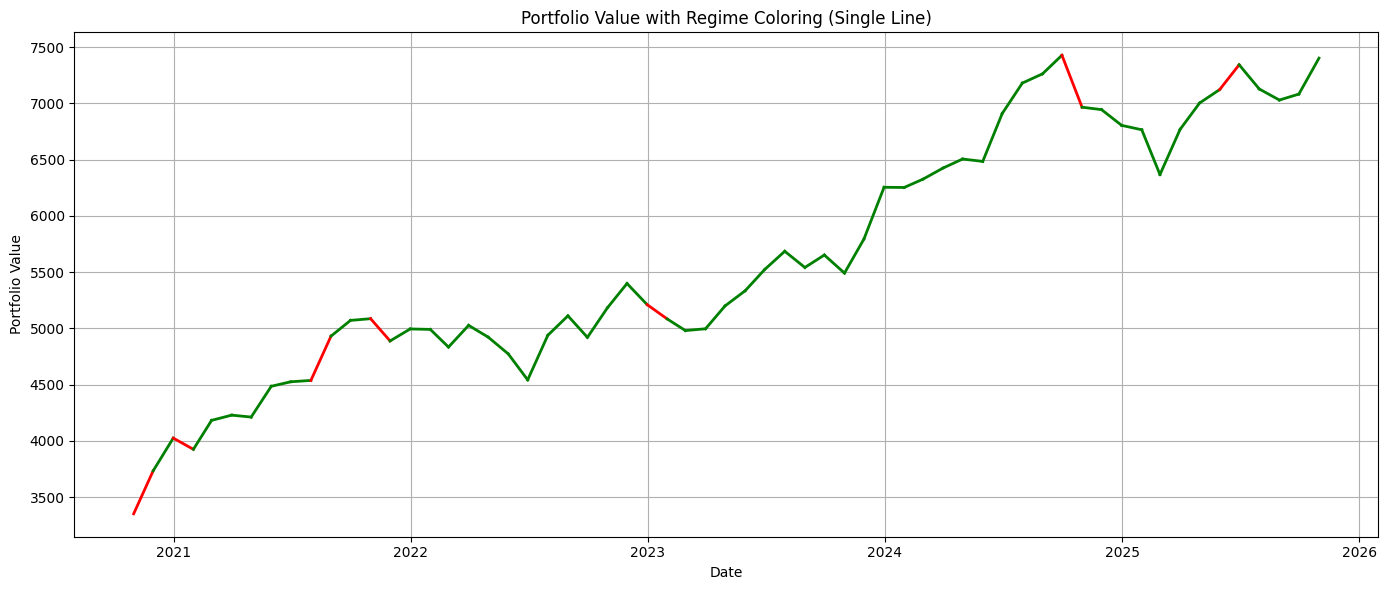

In [ ]:
# Merge Portfolio and Predicted_Regime, shift regime by 1 month
portfolio_regime_df = pd.DataFrame({
    "Portfolio": market_data["Portfolio"]
}).merge(
    test_output_df[["Predicted_Regime"]].shift(1), 
    left_index=True, right_index=True, how="left"
)

portfolio_regime_df = portfolio_regime_df.dropna()

# Plot a single line, colored by regime
plt.figure(figsize=(14,6))
colors = {0: "red", 1: "green"}
regimes = portfolio_regime_df["Predicted_Regime"].values
portfolio = portfolio_regime_df["Portfolio"].values
dates = portfolio_regime_df.index

for i in range(1, len(portfolio)):
    plt.plot(dates[i-1:i+1], portfolio[i-1:i+1], color=colors[regimes[i]], linewidth=2)

plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value with Regime Coloring (Single Line)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Miscelleneous

In [ ]:
pair_1 = ['momentum_1_1_zscore',
 'momentum_6_1_zscore']

pair_2 = ['BSE Sensex CAPE 5_zscore']
pair_3 = ['inflation_rate_zscore']
pair_4 = ['World_Equity_zscore']
pair_5 = ['USDINR=X_zscore']

feature_pairs = [pair_1, pair_2, pair_3, pair_4, pair_5]

split_of_date_to_use = round(0.8*len(market_data_clean))
for feature_pair in feature_pairs:
       print(feature_pair)
       X = market_data_clean[list(feature_pair)].iloc[:split_of_date_to_use]
       y = market_data_clean['regime'].iloc[:split_of_date_to_use]

       # Initialize the Random Forest Classifier
       clf = RandomForestClassifier(n_estimators=10, random_state=42)

       # Define k-fold cross-validation (-fold)
       kfold = StratifiedKFold(n_splits=10, shuffle=False)

       # Perform cross-validation
       cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

       # Train the model
       clf.fit(X, y)

       # Output results
       print(f"Cross-Validation Scores: {cv_scores}")
       print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
       print(f"Standard Deviation: {np.std(cv_scores):.4f}")



NameError: name 'market_data_clean' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

i = 0
test_data_final = market_data_clean.iloc[split_of_date_to_use:]
for feature_pair in feature_pairs:
    X = market_data_clean[list(feature_pair)].iloc[:split_of_date_to_use]
    y = market_data_clean['regime'].iloc[:split_of_date_to_use]

    # Initialize the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X, y)

    test_data_final['regime' + '_' + str(i)] = clf.predict(test_data_final[feature_pair])
    i+=1



NameError: name 'market_data_clean' is not defined

In [ ]:
test_data_final['regime_prediction'] = test_data_final[[ 'regime_0', 'regime_1', 'regime_2', 'regime_3', 'regime_4']].mode(axis=1)[0]
test_data_final[['regime', 'regime_prediction']]

NameError: name 'test_data_final' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_data_final["regime"], test_data_final["regime_prediction"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

acc_score = accuracy_score(test_data_final["regime"], test_data_final["regime_prediction"])
print(f"Accuracy: {acc_score*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0            1           18
Actual 1            2           51
Accuracy: 72.22%
